# “Go not to the Elves for counsel, for they will say both no and yes.”
-- Frodo Baggins

# Outline

- Brief Pat101

- Introduction to/Context of the problem

- Approach (merits, justification)

- Methods/Code

- Model and its Performance

- Conclusions

![pat101](pat101slide_july2022.PNG)

## THE PROBLEM

# SMILES -> L1

Objective: Predict the L1 classification (e.g. 'Enzyme','Transcription Factor','Membrane protein/receptor') of the *protein* (not plural!) that a ligand may bind to, given the ligand's SMILES code.

ASSUMPTION: Each ligand binds to only one protein. ("SMILES can bind with multiple categories of proteins, but it is rare.")

# Context of the Problem

Ligand Screening, which may be done for many reasons:

- Reduce number of experiments and examine a *MUCH* larger chemical space

- Identify optimal ligands, i.e., the best N therapeutic candidates 

- Study the commonalities of ligands that do bind; e.g. functional groups

Not possible here given the assumption, but with a few modifications:

- Look for x-specific (e.g. bispecific) ligands

- Identify potential off-target effects, likelihood of side-effects... (with identified optimal ligands, see predicted probability of binding to other classes/proteins)

## THE APPROACH

Given 1,000,000+ SMILES Codes and the *VERY* broad L1 Category (15 classes) ...

Chemical Approach:

- Generate/predict a bunch of chemical features (binding energy possible but not likely valuable in this study)

- Identify useful features from past work: see DeepTox

- Comptuationally intensive - use subset of data during development

- Use ML classification algorithms to predict the SINGLE targets of ea. ligand

Pros: 

- Can analyze specific chemical features in post-analysis

- Reasonably modular/scalable; can add more predicted chemical features, docking results, *and assay results if they exist*

Cons:

- Limited structural information, e.g. 'fingerprint'

- Computationally intensive, at least w. RDKIT and one EC2 instance; w. docking etc. much more intensive

- No assays, all data in-silico

Alternative Structural Approach (EXTREMELY NAIVE):

- One-Hot Encode (i.e. 1/0 if character is A, B, or C) the SMILES codes, as strings

- Predict class using convolutional neural network 

- Based on work that followed up on DeepTox; identified interesting common structural features

Pros:

- Identifies relevant, common structures that *ARE* SMILES codes and can be directly re-input to screen for ligands with that feature

- Arguably easier to implement; no chemical knowledge required, but...

Cons:

- ONLY structural data generated; no further analysis can be done, no other features to analyze

Therefore more of a supplementary model to confirm hits or dig into exact structures of interest.

Citations:

DeepTox:

https://www.frontiersin.org/articles/10.3389/fenvs.2015.00080/full
Mayr, Andreas, et al. "DeepTox: toxicity prediction using deep learning." Frontiers in Environmental Science 3 (2016): 80.

CNN/One-Hot:

https://link.springer.com/article/10.1186/s12859-018-2523-5
Hirohara, Maya, et al. "Convolutional neural network based on SMILES representation of compounds for detecting chemical motif." BMC bioinformatics 19.19 (2018): 83-94.

## Method/Codes

In [134]:
# coding: utf-8
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
import pandas as pd
import sys as sys
import os as os
import ast as ast
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import PandasTools
from rdkit import RDConfig
from rdkit.Chem import PandasTools as pdt
from rdkit.Chem import Descriptors as D
from rdkit.Chem import rdMolDescriptors as MD
from xgboost import XGBClassifier
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data loading...

In [81]:

# smiles_l1.csv should be in the same directory as the .ipynb

big_df = pd.read_csv("smiles_l1.csv")  # warning: BIG file

# 1 million (Dr.Evil face) samples! let's get 1%; gives 16 classes including 'unknown'
df = big_df.sample(frac=0.01, replace=False, random_state=11)

# alternative if desired to train the model on EVERYTHING:
# df = big_df

df.dropna() #paranoia

# get those lists in the 2nd column resolved; unknown to me still if they're just dup'd
# using ast.literal_eval enables import as a list w one element rather than an entire list
df.L1_class_name = df.L1_class_name.apply(ast.literal_eval)


In [82]:
df.head()

,canonical_smiles,L1_class_name
1160872,Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...,[Enzyme]
347949,CCOC(=O)C(=O)Nc1cc(C)c(Oc2ccc(O)c(C(C)C)c2)c(C)c1,[Transcription factor]
585208,COCCn1c(=O)nc(Nc2ccc(OC(C)C)c(F)c2)n(Cc2ccc(Cl...,[Ion channel]
1018911,Cc1nc2sc(C(=O)NC3CCOC3)c(N)c2c(C)c1Cl,[Membrane receptor]
1276212,O=C(Nc1ccc(Oc2ccnc(NC(=O)C3CC3)c2)nc1)Nc1ccc(C...,[Enzyme]


In [83]:

df.describe()

,canonical_smiles,L1_class_name
count,14379,14379
unique,14379,16
top,Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...,[Enzyme]
freq,1,6967


# Process L1 Class data...

In [84]:
df['string_L1'] = df['L1_class_name'].apply(lambda x: x[0])
df.head()
# so this lambda fn; we set x = the first and only element in L1_class_name; that
# x becomes string_L1 in our new column. 

# pd DEMANDS you declare your factors and get the KEY of what they are
df['Target_Class'], uniques = pd.factorize(df.string_L1)
df.head()

,canonical_smiles,L1_class_name,string_L1,Target_Class
1160872,Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...,[Enzyme],Enzyme,0
347949,CCOC(=O)C(=O)Nc1cc(C)c(Oc2ccc(O)c(C(C)C)c2)c(C)c1,[Transcription factor],Transcription factor,1
585208,COCCn1c(=O)nc(Nc2ccc(OC(C)C)c(F)c2)n(Cc2ccc(Cl...,[Ion channel],Ion channel,2
1018911,Cc1nc2sc(C(=O)NC3CCOC3)c(N)c2c(C)c1Cl,[Membrane receptor],Membrane receptor,3
1276212,O=C(Nc1ccc(Oc2ccnc(NC(=O)C3CC3)c2)nc1)Nc1ccc(C...,[Enzyme],Enzyme,0


In [85]:
uniques

Index(['Enzyme', 'Transcription factor', 'Ion channel', 'Membrane receptor',
       'Epigenetic regulator', 'Transporter', 'Structural protein',
       'Secreted protein', 'Other cytosolic protein', 'Unclassified protein',
       'Auxiliary transport protein', 'Other membrane protein',
       'Surface antigen', 'Other nuclear protein', 'Adhesion'],
      dtype='object')

# RDKit Molecules and Descriptors...

,canonical_smiles,L1_class_name,string_L1,Target_Class,ROMol
1160872,Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...,[Enzyme],Enzyme,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
347949,CCOC(=O)C(=O)Nc1cc(C)c(Oc2ccc(O)c(C(C)C)c2)c(C)c1,[Transcription factor],Transcription factor,1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
585208,COCCn1c(=O)nc(Nc2ccc(OC(C)C)c(F)c2)n(Cc2ccc(Cl...,[Ion channel],Ion channel,2,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
1018911,Cc1nc2sc(C(=O)NC3CCOC3)c(N)c2c(C)c1Cl,[Membrane receptor],Membrane receptor,3,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
1276212,O=C(Nc1ccc(Oc2ccnc(NC(=O)C3CC3)c2)nc1)Nc1ccc(C...,[Enzyme],Enzyme,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

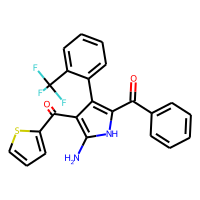
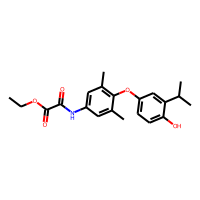
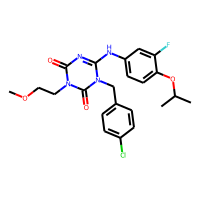
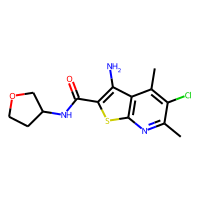
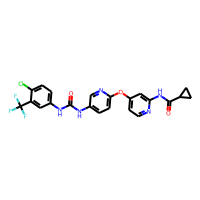

In [86]:
# takes ~ 26 seconds with 1% of data and t3.xlarge
pdt.AddMoleculeColumnToFrame(df, 'canonical_smiles', includeFingerprints=True)
df.head()

# Salt processing...

Salts are relevant here, but there were several molecules that only differed by number of salts; don't wanna bias the data with duplicates so:

In [87]:
# It contains all the salts that I could find (searching through the .csv for .[] etc.) in this dataset
remover = SaltRemover(defnData="[Cl,Br,Zn,Mg,Ca,Sr,Na,K]")

# in this case we don't add a new column, just apply a function to the molecules
df['ROMol'].apply(lambda x: remover.StripMol(x))

df['Cleaned_SMILES'] = df['ROMol'].apply(lambda x: Chem.MolToSmiles(x))

# an alternative method in pandasTools, but not sure how it defines the SaltRemover:
# http://rdkit.org/docs/source/rdkit.Chem.PandasTools.html
# rdkit.Chem.PandasTools.RemoveSaltsFromFrame(frame, molCol='ROMol')


,canonical_smiles,L1_class_name,string_L1,Target_Class,ROMol,Cleaned_SMILES
1160872,Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...,[Enzyme],Enzyme,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...
347949,CCOC(=O)C(=O)Nc1cc(C)c(Oc2ccc(O)c(C(C)C)c2)c(C)c1,[Transcription factor],Transcription factor,1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CCOC(=O)C(=O)Nc1cc(C)c(Oc2ccc(O)c(C(C)C)c2)c(C)c1
585208,COCCn1c(=O)nc(Nc2ccc(OC(C)C)c(F)c2)n(Cc2ccc(Cl...,[Ion channel],Ion channel,2,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",COCCn1c(=O)nc(Nc2ccc(OC(C)C)c(F)c2)n(Cc2ccc(Cl...
1018911,Cc1nc2sc(C(=O)NC3CCOC3)c(N)c2c(C)c1Cl,[Membrane receptor],Membrane receptor,3,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Cc1nc2sc(C(=O)NC3CCOC3)c(N)c2c(C)c1Cl
1276212,O=C(Nc1ccc(Oc2ccnc(NC(=O)C3CC3)c2)nc1)Nc1ccc(C...,[Enzyme],Enzyme,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",O=C(Nc1ccc(Oc2ccnc(NC(=O)C3CC3)c2)nc1)Nc1ccc(C...

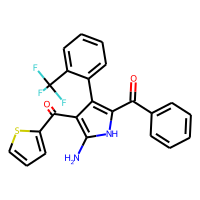
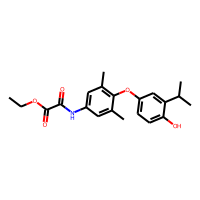
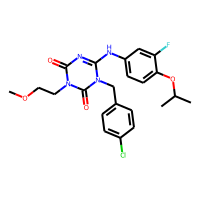
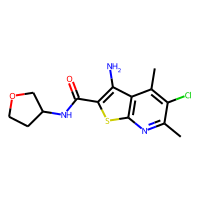
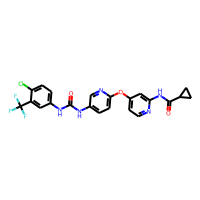

In [88]:
df.head()

In [89]:
# we're gonna get rid of duplicates, let's see original sample #s:
df.describe()

,Target_Class
count,14379.000000
mean,2.233465
std,2.907931
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,14.000000


In [90]:
# now drop duplicate mols based on cleaned up smiles

# Drop the duplicate mols, keep only the first one; big danger
# that some of the salts may matter... but one of those samples had like
# 20 salts and that's real sus to me
df = df.drop_duplicates(subset='Cleaned_SMILES',keep='first') 
df.describe()

# welp, in this sample we all gucci. w. settings:
# df = big_df.sample(frac=0.01, replace=False, random_state=11)

,Target_Class
count,14379.000000
mean,2.233465
std,2.907931
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,14.000000


# Feature Generation (finally)

In [91]:
# takes ~30 seconds, 1% data, t3.xlarge

# topological polar surface area for the molecule; 
# poking around the data it seemed there were a number
# of polar phosphate-salt groups, so the S and P option is used
# ... without noticeable effect on end results vs. not including S and P, I'll add
df['TPSA'] = df['ROMol'].apply(lambda x: D.TPSA(x, includeSandP = True))
df['LabuteASA'] = df['ROMol'].apply(lambda x: MD.CalcLabuteASA(x))

# the rest I think require less explanation:
df['MolLogP'] = df['ROMol'].apply(lambda x: D.MolLogP(x))
df['MolWt'] = df['ROMol'].apply(lambda x: D.MolWt(x))
df['MaxPartialCharge'] = df['ROMol'].apply(lambda x: D.MaxPartialCharge(x))
df['MinPartialCharge'] = df['ROMol'].apply(lambda x: D.MinPartialCharge(x))
df['HeavyAtomMolWt'] = df['ROMol'].apply(lambda x: D.HeavyAtomMolWt(x))
# COMES OUT TO 0, SO LEAVE THIS FEATURE O-U-T OUT!
# df['NumRadicalElectrons'] = df['ROMol'].apply(
    # lambda x: D.NumRadicalElectrons(x))
df['NumValenceElectrons'] = df['ROMol'].apply(
    lambda x: D.NumValenceElectrons(x))
df['NumHAcceptors'] = df['ROMol'].apply(lambda x: D.NumHAcceptors(x))
df['NumHDonors'] = df['ROMol'].apply(lambda x: D.NumHDonors(x))
df['NumAromaticRings'] = df['ROMol'].apply(lambda x: D.NumAromaticRings(x))

# ... except for these, which I thought could be interesting;
# Morgan fingerprint, at least my perception, is somewhat analagous to ECFP:
# https://pubs.acs.org/doi/10.1021/ci100050t
# Rogers, David, and Mathew Hahn. "Extended-connectivity fingerprints." Journal of chemical information and modeling 50.5 (2010): 742-754.
# this exact implementation here in RDKit is... honestly not too clearly documented
# but I thought it'd be interesting to include; the visual implementation is more informative than this number I think

df['FpDensityMorgan1'] = df['ROMol'].apply(lambda x: D.FpDensityMorgan1(x))
df['FpDensityMorgan2'] = df['ROMol'].apply(lambda x: D.FpDensityMorgan2(x))
df['FpDensityMorgan3'] = df['ROMol'].apply(lambda x: D.FpDensityMorgan3(x))

# OG paper:
# https://pubs.acs.org/doi/pdf/10.1021/c160017a018
# 1965!! 
# Morgan, Harry L. "The generation of a unique machine description for chemical structures-a technique developed at chemical abstracts service." Journal of chemical documentation 5.2 (1965): 107-113.

# more LOTR:
# Capecchi, Alice, Daniel Probst, and Jean-Louis Reymond. 
# "One molecular fingerprint to rule them all: drugs, biomolecules, and the metabolome." Journal of cheminformatics 12.1 (2020): 1-15.

# Move Y to the end...

And see data types, sanity check

In [92]:
# I'm more familiar with data wrangling in R so,
# credit to Charlie Haley from this stackoverflow, this operation IMO is easier in R:
# https://stackoverflow.com/questions/35321812/move-column-in-pandas-dataframe
# Charlie Haley's answer 

colNames = df.columns.values
colNames = list(df.columns.values)
colNames.pop(colNames.index('Target_Class'))
df = df[colNames + ['Target_Class']]

# this manipulation though is potentially the source of some error I was having in the next step, so out of paranoia:
df.dropna()
df.dtypes

canonical_smiles        object
L1_class_name           object
string_L1               object
ROMol                   object
Cleaned_SMILES          object
TPSA                   float64
LabuteASA              float64
MolLogP                float64
MolWt                  float64
MaxPartialCharge       float64
MinPartialCharge       float64
HeavyAtomMolWt         float64
NumValenceElectrons      int64
NumHAcceptors            int64
NumHDonors               int64
NumAromaticRings         int64
FpDensityMorgan1       float64
FpDensityMorgan2       float64
FpDensityMorgan3       float64
Target_Class             int64
dtype: object

-----------------------
# PROBABLY A GOOD SPOT TO LOOK AT OUR DATA, AND THEN GO INTO AN UPGRADED ML WORKFLOW

In [93]:
df.describe()

# interesting that labute came out lower than TPSA. Just differences in how they calcualted I guess

,TPSA,LabuteASA,MolLogP,MolWt,MaxPartialCharge,MinPartialCharge,HeavyAtomMolWt,NumValenceElectrons,NumHAcceptors,NumHDonors,NumAromaticRings,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,Target_Class
count,14379.000000,14379.000000,14379.000000,14379.000000,14370.000000,14370.000000,14379.000000,14379.000000,14379.000000,14379.000000,14379.000000,14379.000000,14379.000000,14379.000000,14379.000000
mean,101.834871,179.651384,3.344886,432.446475,0.281702,-0.431177,407.447671,159.825023,5.588358,1.962584,2.591140,1.086581,1.799376,2.466042,2.233465
std,105.184530,97.368237,2.280835,239.382679,0.094636,0.084036,223.310391,92.775491,3.823630,3.596666,1.213286,0.206154,0.279594,0.344687,2.907931
min,0.000000,29.563850,-50.835700,75.067000,-0.003670,-1.000000,70.027000,26.000000,0.000000,0.000000,0.000000,0.137931,0.227586,0.324138,0.000000
25%,63.780000,138.820754,2.387150,332.466000,0.235837,-0.492771,313.670000,122.000000,4.000000,1.000000,2.000000,0.968750,1.666667,2.320000,0.000000
50%,86.930000,166.609882,3.459080,400.482000,0.267071,-0.457967,378.235000,146.000000,5.000000,1.000000,3.000000,1.090909,1.826087,2.516129,1.000000
75%,113.305000,196.888166,4.551050,473.542500,0.328891,-0.366179,447.291000,174.000000,7.000000,2.000000,3.000000,1.216216,1.968750,2.684211,3.000000
max,2243.780000,1952.188312,16.229200,4857.464000,1.000000,1.000000,4565.601000,1848.000000,119.000000,70.000000,24.000000,2.000000,2.666667,3.416667,14.000000


Alright so let's take some notes on what I'm seeing just from this table, decide what to target with graphs:
- TPSA - a minimum of 0??? need to dig into the data and make sure this isn't an error. It is POLAR surface area, and I'd expect a considerable number of nonpolar molecules. Maybe we can just decide on a threshold to consider 'nonpolar' and keep that feature.
- No radical electrons. Remove this feature. Only throws things off.
- MAXIMUM OF 1848 VALENCE ELECTRONS?? Wtf is that molecule??
- Rest looks OK. Again would be preferable to have like assays or maybe even docking results, but w/e. So just TPSA and valence to look at in depth.

------
Let's make sure we got a good handle on the literature/theory:

OG TPSA paper: https://pubmed.ncbi.nlm.nih.gov/11020286/
Ertl, Peter, Bernhard Rohde, and Paul Selzer. "Fast calculation of molecular polar surface area as a sum of fragment-based contributions and its application to the prediction of drug transport properties." Journal of medicinal chemistry 43.20 (2000): 3714-3717.
- "A new approach for the calculation of the PSA is presented here, based on the summation of tabulated surface contributions of polar fragments. "
https://peter-ertl.com/reprints/Ertl-JMC-43-3714-2000.pdf
Literally sees fragments, eg ROH, and looks up a calculated PSA value and just sums 'em up for the molecule. Really nifty. And comes out pretty well, TPSA ~ PSA

(btw: QSAR = quantitative structure-activity relationship... so just what we're doing lol but sounds cool)
A paper discussing TPSA: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7549127/
Prasanna, S., and R. J. Doerksen. "Topological polar surface area: a useful descriptor in 2D-QSAR." Current medicinal chemistry 16.1 (2009): 21-41.
- Basically an approximation, in 2D, of the potential for polar interactions, negating the need for 3D calculations. NOT perfect. The authors note specifically: 
- "The first limitation is the inability of TPSA to capture the activity difference of compounds differing only in their non polar groups... The second limitation stems from the fact that TPSA calculation does not include the influence of positional changes of functional groups. For example, a polar group in ortho, meta or para position or even placed at a different place in the molecule would contribute the same amount to the TPSA."

---

Conclusion: Look for an additional measure of SA in RDKit; don't wanna risk RDKit molecule being incompatible or needing to calc a whole other thing. 

There is labute accessible surface area (ASA);  more inclusive of nonpolar groups, arguably better idea of surface area. Many more descriptors are available, listed here: https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors and here: https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html 
Curiously 'FreeSASA' is an empty module: https://www.rdkit.org/docs/source/rdkit.Chem.rdFreeSASA.html; I found documentation here for how to call it:  https://iwatobipen.wordpress.com/2019/11/07/calculate-free-solvent-accessible-surface-area-rdkit-chemoinformatics/. 

So! Labute. And then we just look at the valence electron distributions, maybe exclude a cluster of weird molecules.

From: https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html

In [94]:
# here we have it! also many more descriptors which may be useful, but I think just uhm, excessive beyond this:
# MD.CalcLabuteASA

# GONNA MOVE THIS UP!!
# df['LabuteASA'] = df['ROMol'].apply(lambda x: MD.CalcLabuteASA(x))
# df.head()

# looks p. different from TPSA! 

# Alrighty then! Let's get looking at some distributions of the data to make sure there's nothing really funky. Really curious about TPSA/Labute and that maximum of valence electrons/molwt. The rest I suspect will be more reasonable. After that, upgrade the ML below for GraphCV, include more models, MAYBE PyTorch. Otherwise... enough.

Let's first understand the makeup of the data we're working with, my impression is 'Enzyme' is *VERY* populous in this dataset.

Index(['Enzyme', 'Transcription factor', 'Ion channel', 'Membrane receptor',
       'Epigenetic regulator', 'Transporter', 'Structural protein',
       'Secreted protein', 'Other cytosolic protein', 'Unclassified protein',
       'Auxiliary transport protein', 'Other membrane protein',
       'Surface antigen', 'Other nuclear protein', 'Adhesion'],
      dtype='object')

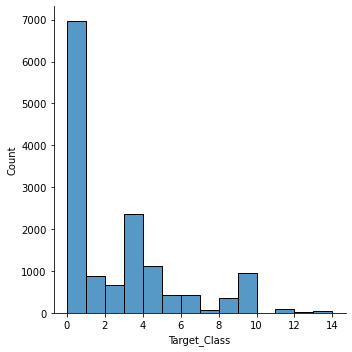

In [97]:
# Gonna do 3 graphs that I think will be informative, hopefully replace the above 2 pandas sad graphs.

# 1. Let's understand the difference in the counts of data coming in.
# use custom bins to avoid nasty open spaces
sns.displot(df, x='Target_Class',bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
uniques

Looking at this, it's again clear that 'Enzyme' is really overrepresented in this dataset. And while I had the initial temptation to pull equal amounts of data from each category, looking at the minimum here... it's going to be a *very* small subset of this data.

Therefore, we'll make note to try considerably high values for the... whatever parameter enforces placing greater weight on the minority classes. In XGB, it's scale_pos_weight, as far as I know; we'll look for the other ML algorithms also.

Now let's look how the data distributes by class, see if we can see any interesting things. I also wanna look at precisely how much TPSA and LSA differ.

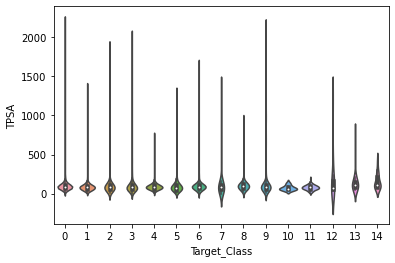

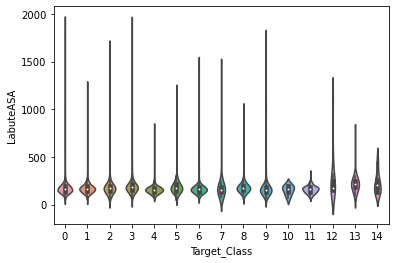

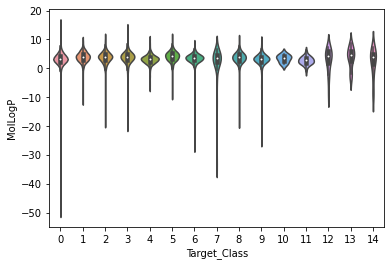

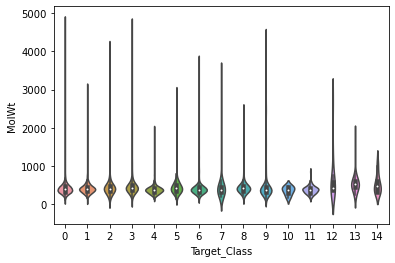

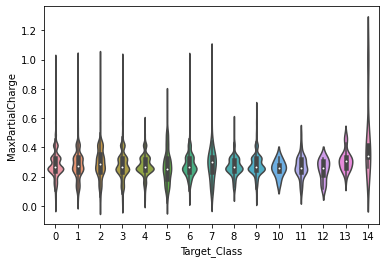

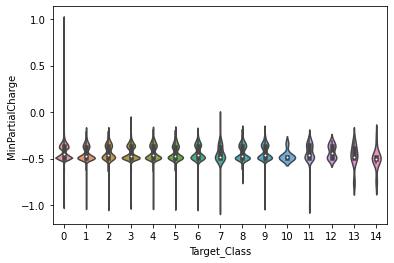

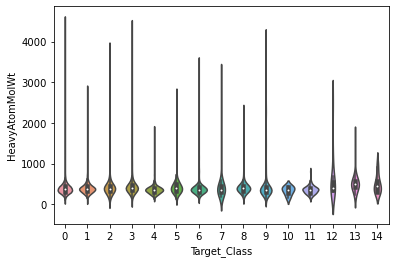

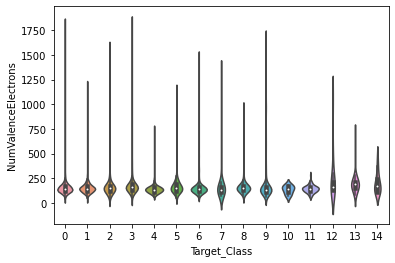

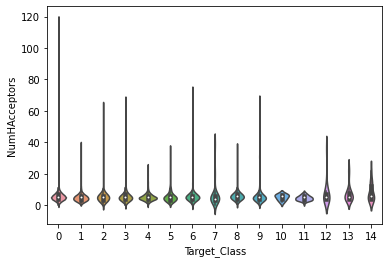

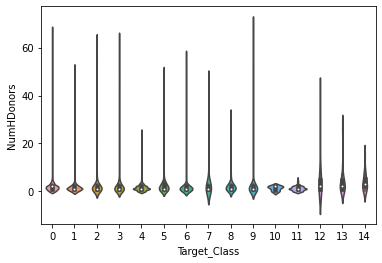

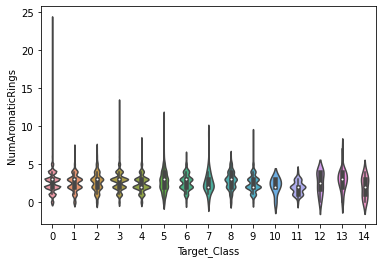

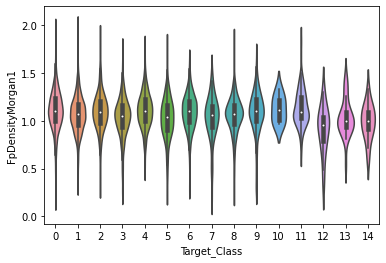

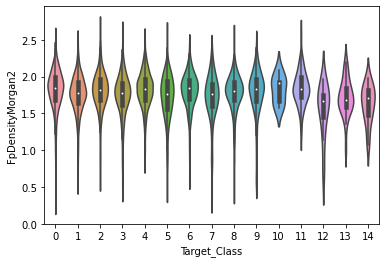

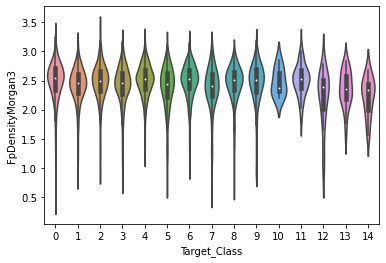

In [108]:
# let's try doing class by properties first, then a bunch of graphs.
# g = sns.FacetGrid(df, hue = "Target_Class")
# g.map(sns.scatterplot,"TPSA",)

# let's define a list of our features...
features = ['TPSA', 'LabuteASA', 'MolLogP', 'MolWt', 'MaxPartialCharge', 'MinPartialCharge', 'HeavyAtomMolWt', 'NumValenceElectrons',
                                                    'NumHAcceptors', 'NumHDonors', 'NumAromaticRings', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3']

for i in range(len(features)):
    sns.violinplot(x="Target_Class", y = features[i], data=df)
    plt.show()
# g_tpsa = sns.violinplot(x="Target_Class",y="TPSA",data=df)

What I gather from all these is that we'll see the extremes of classes be easily categorized to their proper class, but the remainder will be a struggle and be based on probably all their features in tandem. 

This does explain the poor performance I was getting without any optimization or upfront analysis. And while I'm tempted to remove the extremes, perhaps outside two deviations, I don't think this would necessarily be appropriate in the full dataset, and could be an artefact of taking random subsamples. So I'll hold off for now.

I am still curious if we zoom in on the TPSA and LASA, if we can tuss out some differences...

Index(['Enzyme', 'Transcription factor', 'Ion channel', 'Membrane receptor',
       'Epigenetic regulator', 'Transporter', 'Structural protein',
       'Secreted protein', 'Other cytosolic protein', 'Unclassified protein',
       'Auxiliary transport protein', 'Other membrane protein',
       'Surface antigen', 'Other nuclear protein', 'Adhesion'],
      dtype='object')

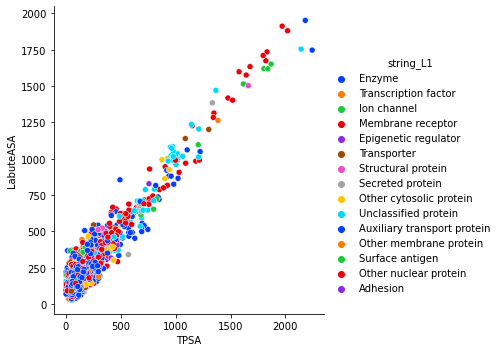

In [114]:
# let's try for the moon first, then just compare the raw numbers...
# g = sns.FacetGrid(tips, col="sex", hue="smoker")
# g.map(sns.scatterplot, "total_bill", "tip", alpha=.7)
# g.add_legend()

# g = sns.FacetGrid(df, col = "")

# sns.relplot(x="horsepower", y="mpg", hue="origin", size="weight",
            # sizes=(40, 400), alpha=.5, palette="muted",
            # height=6, data=mpg)

sns.relplot(x='TPSA',y='LabuteASA',hue="string_L1", palette="bright",data=df)
uniques        

Ok, so we largely see that these are somewhat interchangeable estimates, but interestingly, we do see lots of red and green, so target class 2 and 3, ion channels and membrane receptors! This also offers us a decent cutoff to examine these really big molecules and have a reasonably small sample to take a manual look at.

So let's try grouping by those samples and make sure they're... informative for our models, not just crackpot molecules.

In [118]:
bigMols = df[df.LabuteASA > 1250]

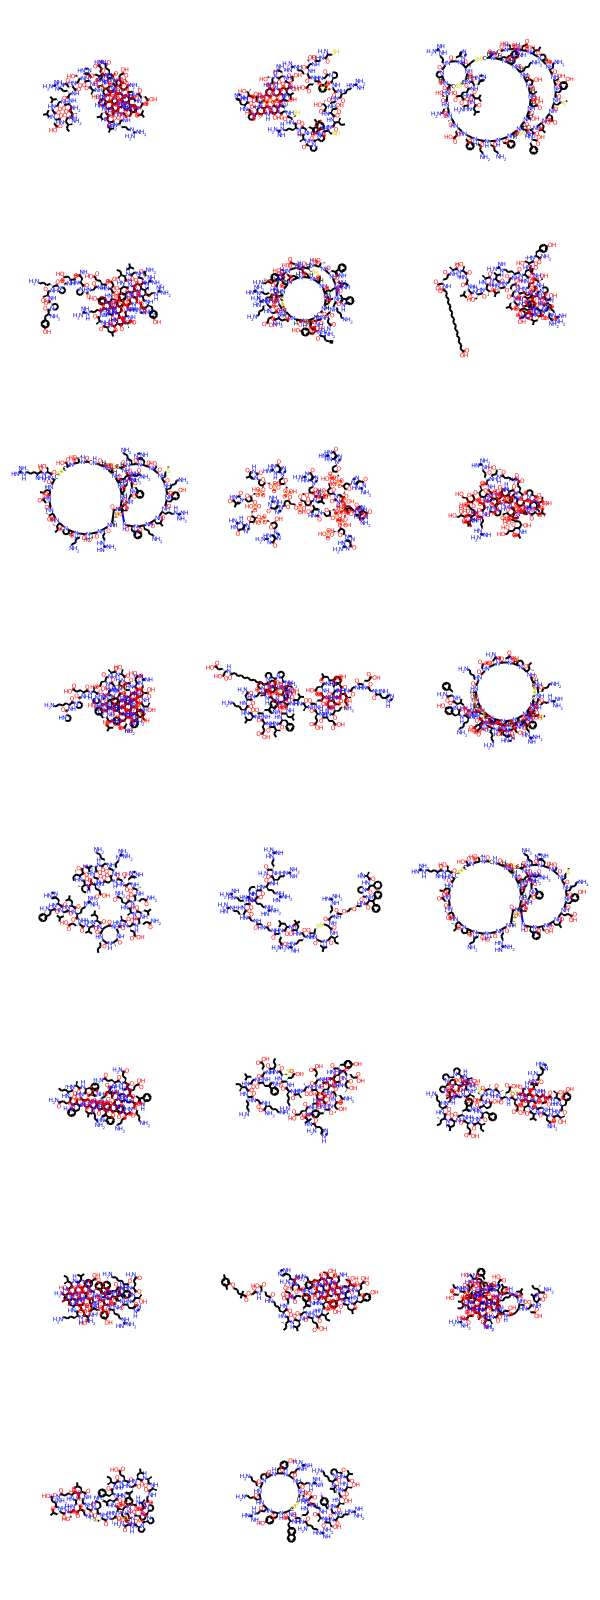

In [125]:
bigMols.describe()

# WELL. In 1% of the data, like 10k samples, we get 23, TWENTY-THREE big molecules. 

pdt.FrameToGridImage(bigMols)


WHAAAAAAT. Never thought I'd describe molecules as beautiful. But. Also... probably crappy noise. So let's... have an option here of just clearing out the noise, can try it below in the ML. But wowz!

In [130]:
noExtremesdf = df[df.LabuteASA < 500] # tried with <1250 also

In [132]:
# try again:
# for i in range(len(features)):
#     sns.violinplot(x="Target_Class", y = features[i], data=noExtremesdf)
#     plt.show()

Ehhhh not clear there's an improvement in the shape of distributions -- just fewer extremes, I'll save this as an option during training, maybe just take the best ML and try again with less extremes. My suspicion is that eliminating data willy-nilly etc. is not a good move. But this is interesting.

One last thing, let's get the correlation of different features with each other, code is pretty straightforward:

<AxesSubplot:>

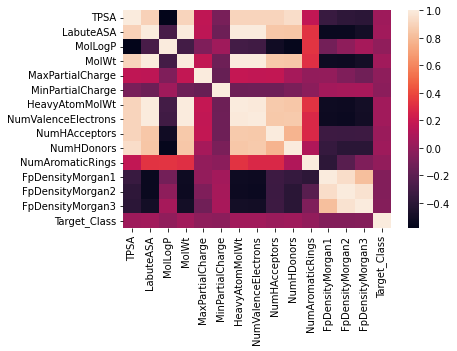

In [135]:
# One more graph, the correlations of all these features w... ea. other.
sns.heatmap(df.corr())

So -- let's look at correlations with Target Class ... pretty much ~0. So that's uh... not awesome. The morgan fingerprints are all pretty close to each other, maybe we'd get away with just fpdensity1. MolWt correlates with surface area and numbers of electrons, donors, etc.

This does provide a nice interpretation of morgan density; negatively correlated with larger molecules. Aromatic rings correlated with other things that serve as a measure of the size of the molecule.

Let's remember MolLogP is effectively preference for polar (lower logP value) and nonpolar (higher logP) environmnents. Negatively correlated with more hydrogen donors/acceptors, polar groups, which is correct, and also with surface areas, more solvent accessible, so that also... mostly checks out. Positively with aromatic rings, so that's cool.

But yeah. *VERY* poor correlation with Target Class. So let's go through grid search, but I'm thinking no on implementing any PyTorch stuff.

# Split the data:

In [99]:
x_train, x_test, y_train, y_test = train_test_split(df[features], df.Target_Class, test_size=0.2, random_state=1)


Note random state = 1 is specified above, so I can discuss the results with confidence they're the same... although getting different data (from sampling df from big_df above) didn't seem to make much difference anyway.

Now, scale/normalize our data:

# Normalize data:

In [100]:
# there's some really nice documentation on pipelines in python using scikit,
# but imo stil not as nice as R w. pipe operators
# https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

sc = StandardScaler() # from sci-kit
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test) # use same fit as w. training

# and not appropriate to transform the Y data

I favor XGBoost for multiclassification problems; I did some hyperparameter tuning off-screen to... no noticeable difference, so, mostly/all defaults:

# Parameter definition/setup:

In [101]:
df.Target_Class.describe() 
# max of 14, i.e. 0 - > 14 therefore 15 classes

count    14379.000000
mean         2.233465
std          2.907931
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         14.000000
Name: Target_Class, dtype: float64

In [140]:
x_train_xg = xgb.DMatrix(x_train, label=y_train)
x_test_xg = xgb.DMatrix(x_test,  label=y_test)
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
# from XGBoost website: "DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed"

params = {} # initialize

# these two will not be changed:

# for classification, using softmax
# multi:softprob can also be used, outputs all probabilities
# would therefore be useful in, for example, off-target studies
params['objective'] = 'multi:softmax' 
params['num_class'] = 15 # 0 - 14 indeces for the L1 classes

# search for these bad boys:
# GONNA USE BELOW!
# params ={
#     'eta':[0.005,0.01,0.1,0.3],
#     'max_depth':[6,8,10], # mucho potential for overfit, but may help!
#     'scale_pos_weight':[1,100,1000],
#     'n_estimators':[100,150,200]
# }

epochs = 10  # seems to work best, 1000 didn't improve accuracy 

# to see evolution of the model:
watchlist = [(x_train_xg, 'train'), (x_test_xg, 'test')]


params['eta'] = 0.3  # DEFAULT 0.3; aka learning_rate
params['max_depth'] = 6  # DEFAULT 6
params['scale_pos_weight'] = 1 # default 1 so let's see , # i think??

And now for our model!!...

# MODELING!

In [141]:
# THE MAGIC!!!!!!

# BEGIN HYPERPARAM OPTIMIZATION ----------------

# XG = xgb.XGBClassifier() # still specify softmax for multi-class, same thing is used for logistic

# griddyXG = GridSearchCV(XGBClassifier(),
#                         params,
#                         cv = 5, #5-fold cross-val
#                         )

# griddyXG.fit(x_train, y_train)
# print("Best score from grid search:")
# griddyXG.best_score_
# print("The winning parameters:")
# griddyXG.best_params_

# # use this to predict stuff:
# bestXG = griddyXG.best_estimator_

# pred = bestXG.predict(x_test) # hopefully works

# END ------------------------------

 
model = xgb.train(params, x_train_xg, epochs, watchlist)

# get prediction
pred = model.predict(x_test_xg)

# get performance (based on xgboost github)
error_rate = np.sum(pred != y_test) / y_test.shape[0]
print('Overall error using softmax = {}'.format(error_rate))

[06:34:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:34:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:2.13910	test-mlogloss:2.20849
[1]	train-mlogloss:1.93183	test-mlogloss:2.03867
[2]	train-mlogloss:1.79621	test-mlogloss:1.93570
[3]	train-mlogloss:1.69278	test-mlogloss:1.86107
[4]	train-mlogloss:1.61353	test-mloglos

# XGBoost Performance

In [142]:
print('XGB Classification Report...')
print(classification_report(y_test,pred))
print(uniques) # this is the key

XGB Classification Report...
              precision    recall  f1-score   support

           0       0.49      0.94      0.64      1326
           1       0.57      0.04      0.08       178
           2       0.20      0.01      0.02       123
           3       0.44      0.25      0.32       503
           4       0.33      0.00      0.01       259
           5       0.57      0.04      0.08        92
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        69
           9       0.64      0.04      0.07       197
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         5

    accuracy                           0.49      2876
   macro avg       0.22      0.09      0.08      28

/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Ok so:
- Support: # of samples of that class in this dataset, xtrain
- Precision: Actual true positives out of those predicted positives
- Recall: Amount of positives that were predicted by the model, for good or ill; this demonstrates overfit to enzyme, and changing the pos_weight like I thought might help... didn't. Just too many in the dataset and not a viable path to just take equal samples of everything, too many samples lost. Will try with all data instead
- F1 score; a composite of precision and recall; 1.0 is good, 0 is bad; weighted avg most representative of the model's performance. So... uh, bad.




"I'm not angry, just disappointed." Is how I'd describe how I feel about those results. To discuss a little:
'support' details the number of samples of that class, e.g. there were 1326 actual enzyme samples that were fed into the model; of those predictions to be enzymes, half of the predictions were correct; 90% of the enzyme predictions that did occur were good; but, looking at the rest of the data, one can surmise that the model was overfitted to enzymes; they are the vast majority of this sample of the dataset, so it checks out.

I also test a Naive Bayes below, which actually performs even worse; this shows XG is doing better here, but it may be due to overfitting. Either way, not a success; but I'm getting ahead of myself.

# Try with Naive-Bayes

In [143]:

# the sklearn split method is somehow introducing problems

x_train = np.nan_to_num(x_train)
y_train = np.nan_to_num(y_train)
x_test = np.nan_to_num(x_test)
y_test = np.nan_to_num(y_test)

# VERY STRANGE! BUT PREVENTS BELOW FROM EXPERIENCING HORRIBLE ERRORS

modelGNB = GaussianNB()
modelGNB.fit(x_train, y_train)

gnb_pred = modelGNB.predict(x_test)
print("GNB overall accuracy:")
print(metrics.accuracy_score(y_test, gnb_pred))
print("GNB Classification Report...")
print(classification_report(y_test,gnb_pred))

GNB overall accuracy:
0.2527816411682893
GNB Classification Report...
              precision    recall  f1-score   support

           0       0.48      0.40      0.43      1326
           1       0.25      0.02      0.04       178
           2       0.00      0.00      0.00       123
           3       0.23      0.03      0.05       503
           4       0.12      0.67      0.20       259
           5       0.09      0.03      0.05        92
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        69
           9       0.00      0.00      0.00       197
          10       0.00      0.00      0.00         2
          11       0.02      0.18      0.03        11
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          14       0.10      0.20      0.13         5

    accuracy                           0.25      2876
   macro a

/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

--------------------------------------------
# WELL THAT SUCKS. 

# Summarizing...

- We started with SMILES codes for ONE MILLION+ molecules and took a small subset


- Converted those SMILES codes to RDKit Molecule objects; removed salts/duplicates


- Generated several chemical properties (IN SILICO PREDICTION)


- Examined their distributions and correlations with target classes


- Fit a model to the data (using parameters prev. determined as optimal)


- Evaluated the saddening model performance

# Conclusions

- The chemical space is VAST and it is VERY difficult to make any generalizations/predictions about a ligand and what all it may bind to, without any additional information


- One can do A LOT with just a SMILES code

# Future Work

- Dock predicted 3d structures with representative proteins per class; requires more specific/narrow study objectives


- Could look at multiple targets (raw predicted probabilities per class)


- Integrate assay data


- Cross reference with structural data/alternative approach

# That's all Folks!